# Guided Project: Building a Spam Filter with Naive Bayes

## Introduction

In this project, we'll be building a spam filter for SMS messages with Naive Bayes algorithm.
To classify messages as spam or non-spam, we saw in the previous lesson that the computer:

- Learns how humans classify messages.
- Uses that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam.
- Classifies a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message).

So our first task is to "teach" the computer how to classify messages. To do that, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). 

## Exploring the Dataset

In [1]:
# Read in the dataset
import pandas as pd
sms = pd.read_csv("SMSSpamCollection", header=None, names=['Label', 'SMS'], sep='\t')
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [2]:
sms.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Percentages of spam vs ham messages
sms["Label"].value_counts(normalize=True)*100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

## Training and Test Set

Before building a spam filter, it's very helpful to first think of a way of testing how well it works. When creating software (a spam filter is software), a good rule of thumb is that designing the test comes before creating the software. If we write the software first, then it's tempting to come up with a biased test just to make sure the software passes it.

Once our spam filter is done, we'll need to test how good it is with classifying new messages. To test the spam filter, we're first going to split our dataset into two categories:

- A training set, which we'll use to "train" the computer how to classify messages.
- A test set, which we'll use to test how good the spam filter is with classifying new messages.

We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

- The training set will have 4,458 messages (about 80% of the dataset).
- The test set will have 1,114 messages (about 20% of the dataset).

To better understand the purpose of putting a test set aside, let's begin by observing that all 1,114 messages in our test set are already classified by a human. When the spam filter is ready, we're going to treat these messages as new and have the filter classify them. Once we have the results, we'll be able to compare the algorithm classification with that done by a human, and this way we'll see how good the spam filter really is.

For this project, our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

In [4]:
# Randomise the dataset
df = sms.sample(frac=1, random_state=1)
df

,Label,SMS
1078,ham,"Yep, by the pretty sculpture"
4028,ham,"Yes, princess. Are you going to make me moan?"
958,ham,Welp apparently he retired
4642,ham,Havent.
4674,ham,I forgot 2 ask ü all smth.. There's a card on ...
...,...,...
905,ham,"We're all getting worried over here, derek and..."
5192,ham,Oh oh... Den muz change plan liao... Go back h...
3980,ham,CERI U REBEL! SWEET DREAMZ ME LITTLE BUDDY!! C...
235,spam,Text & meet someone sexy today. U can find a d...


In [5]:
training_index = round(df.shape[0]*0.8)
training_set = df[:training_index].reset_index(drop=True)
training_set

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...
...,...,...
4453,ham,"Sorry, I'll call later in meeting any thing re..."
4454,ham,Babe! I fucking love you too !! You know? Fuck...
4455,spam,U've been selected to stay in 1 of 250 top Bri...
4456,ham,Hello my boytoy ... Geeee I miss you already a...


In [6]:
test_set = df[training_index:].reset_index(drop=True)
test_set

,Label,SMS
0,ham,Later i guess. I needa do mcat study too.
1,ham,But i haf enuff space got like 4 mb...
2,spam,Had your mobile 10 mths? Update to latest Oran...
3,ham,All sounds good. Fingers . Makes it difficult ...
4,ham,"All done, all handed in. Don't know if mega sh..."
...,...,...
1109,ham,"We're all getting worried over here, derek and..."
1110,ham,Oh oh... Den muz change plan liao... Go back h...
1111,ham,CERI U REBEL! SWEET DREAMZ ME LITTLE BUDDY!! C...
1112,spam,Text & meet someone sexy today. U can find a d...


We'll now analyze the percentage of spam and ham messages in the training and test sets. We expect the percentages to be close to what we have in the full dataset, where about 87% of the messages are ham, and the remaining 13% are spam.

In [7]:
training_set['Label'].value_counts(normalize=True)

ham     0.86541
spam    0.13459
Name: Label, dtype: float64

In [8]:
test_set['Label'].value_counts(normalize=True)

ham     0.868043
spam    0.131957
Name: Label, dtype: float64

## Data Cleaning

To calculate all the probabilities required by the algorithm, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need.

Essentially, we want to bring data to this format:

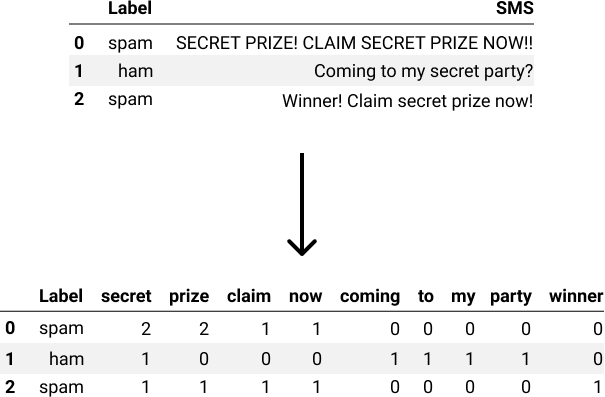

## Lettercase and Punctuation

In [9]:
# Remove punctuation from SMS column
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ', regex=True)
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


## Creating the Vocabulary

Next, we'll create a vocabulary for the messages in the training set. The vocabulary should be a Python list containing all the unique words across all messages, where each word is represented as a string.

In [10]:
# Initiate an empty list
vocabulary = []

# Transform each message from the SMS column into a list
training_set['SMS'] = training_set['SMS'].str.split()
training_set['SMS']

0                       [yep, by, the, pretty, sculpture]
1       [yes, princess, are, you, going, to, make, me,...
2                         [welp, apparently, he, retired]
3                                                [havent]
4       [i, forgot, 2, ask, ü, all, smth, there, s, a,...
                              ...                        
4453    [sorry, i, ll, call, later, in, meeting, any, ...
4454    [babe, i, fucking, love, you, too, you, know, ...
4455    [u, ve, been, selected, to, stay, in, 1, of, 2...
4456    [hello, my, boytoy, geeee, i, miss, you, alrea...
4457                              [wherre, s, my, boytoy]
Name: SMS, Length: 4458, dtype: object

In [11]:
# Loop over the SMS column
for message in training_set["SMS"]:
    for word in message:
        vocabulary.append(word)

In [12]:
# Transform the vocabulary list into a set
vocabulary = set(vocabulary)
type(vocabulary)

set

In [13]:
# Transform the vocabulary set back into a list
vocabulary = list(vocabulary)

In [14]:
len(vocabulary)

7783

## The Final Training Set

We're now going to use the vocabulary we just created to make the data transformation we want.

In [15]:
# Create a dictionary
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1


In [16]:
sms_df = pd.DataFrame(word_counts_per_sms)

In [17]:
combined = pd.concat([training_set, sms_df], axis=1)

In [18]:
combined.head()

,Label,SMS,ello,beers,wadebridge,knows,asssssholeeee,senthil,january,vouch4me,...,doit,dates,ordered,cro1327,thinl,staff,devils,attack,legs,signing
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculating Constants First

We're now done with cleaning the training set, and we can begin creating the spam filter. The Naive Bayes algorithm will help us with this task.

In [19]:
# Calculate P(Spam) and P(Ham)
spam_messages = combined[combined["Label"] == 'spam']
ham_messages = combined[combined["Label"] == 'ham']
p_spam = len(spam_messages) / len(combined)
p_ham = len(ham_messages) / len(combined)

# Calculate NSpam
spam_messages_col = combined[combined["Label"] == 'spam']["SMS"]
n_spam = 0
for i in spam_messages_col:
    word_per_row = len(i)
    n_spam += word_per_row

# Calculate NHam with alternative solution
ham_messages_col = combined[combined["Label"] == 'ham']["SMS"]
n_ham = 0
for i in ham_messages_col:
    word_per_row = len(i)
    n_ham += word_per_row

In [20]:
# Calculate NVocabulary
n_vocab = len(vocabulary)

# Laplace smoothing
alpha = 1

## Calculating Parameters

Now that we have the constant terms calculated above, we can move on with calculating the parameters. Each parameter will thus be a conditional probability value associated with each word in the vocabulary.

In [21]:
# Initialise two dictionaries for parameters
para_spam = {unique_word: 0 for unique_word in vocabulary}
para_ham = {unique_word: 0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()   # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocab)
    para_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_messages[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocab)
    para_ham[word] = p_word_given_ham
    

## Classifying A New Message

Now that we've calculated all the constants and parameters we need, we can start creating the spam filter. The spam filter can be understood as a function that:

- Takes in as input a new message (w1, w2, ..., wn)
- Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn)
- Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:
    - If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
    - If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
    - If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.

In [22]:
import re

# Create the spam filter function
def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()
    
    # Initiate p_spam_given_message and p_ham_given_message
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    # Iterate over each word in message
    for word in message:
        if word in para_spam:
            p_spam_given_message *= para_spam[word]
        if word in para_ham:
            p_ham_given_message *= para_ham[word]

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [23]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [24]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


##  Measuring the Spam Filter's Accuracy

Next, we'll determine how well the spam filter does on our test set of 1,114 messages.

In [25]:
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in para_spam:
            p_spam_given_message *= para_spam[word]

        if word in para_ham:
            p_ham_given_message *= para_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [26]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Now we can compare the predicted values with the actual values to measure how good our spam filter is with classifying new messages.

In [27]:
correct = 0
total = test_set.shape[0]

In [28]:
# Iterate over the test set DataFrame
for index, row in test_set.iterrows():
    if row["Label"] == row["predicted"]:
        correct +=1
        
# Calculate accuracy
accuracy_value = correct / total
accuracy_value

0.9874326750448833

The accuracy rate is 98.74%, which is higher than our target of having more than 80% of the new messages classified correctly as spam or ham (non-spam).

## Conclusion

In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.74% on the test set, which is an excellent result. We initially aimed for an accuracy of over 80%, but we managed to do way better than that.